## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from sklearn.metrics import accuracy_score
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

100%|██████████| 561753746/561753746 [00:08<00:00, 62688884.42it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


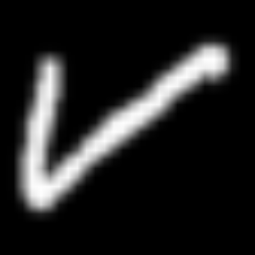

In [3]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [4]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


In [5]:
print(train_data.data.shape)
print(train_data.targets.shape)
print("Number of classes: ", len(train_data.classes))

torch.Size([697932, 28, 28])
torch.Size([697932])
Number of classes:  62


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data.data = train_data.data.reshape(-1,28*28)
test_data.data = test_data.data.reshape(-1,28*28)

import pandas as pd
from sklearn.model_selection import StratifiedKFold

folds = pd.Series(0,index=pd.Series(train_data.targets.numpy()).index)
Fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(train_data.data.numpy(), train_data.targets.numpy())):
    folds[val_index] = int(n)

# Model Arch.
class Model(nn.Module):

  def __init__(self, num_inp, num_out):

    super(Model, self).__init__()

    self.layer_1 = nn.Linear(num_inp, 512)
    self.layer_2 = nn.Linear(512, 256)
    self.layer_3 = nn.Linear(256, 128)
    self.layer_4 = nn.Linear(128, 32)
    self.layer_5 = nn.Linear(32, num_out)

    self.hidden_activation = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    x = self.layer_1(x)
    x = self.hidden_activation(x)

    x = self.layer_2(x)
    x = self.hidden_activation(x)

    x = self.layer_3(x)
    x = self.hidden_activation(x)

    x = self.layer_4(x)
    x = self.hidden_activation(x)

    x = self.layer_5(x)
    x = self.softmax(x)

    return x


In [11]:
# Training loop + validation
import numpy as np
from tqdm import tqdm
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    losses = []
    for step, (inputs, labels) in tqdm(enumerate(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        batch_size = labels.size(0)
        y_preds = model(inputs)
        loss = criterion(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
    return losses


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    preds = []
    losses = []
    for step, (inputs, labels) in tqdm(enumerate(valid_loader)):

        inputs = inputs.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        preds.append(y_preds.to('cpu').numpy())
        losses.append(loss)
    predictions = np.concatenate(preds)
    return losses, predictions

In [14]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.inputs = X.numpy()
        self.labels = y.numpy()
        self.length = len(X)

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        inputs = torch.tensor(self.inputs[item], dtype=torch.float)
        label = torch.tensor(self.labels[item])
        return inputs, label


In [17]:
criterion = torch.nn.CrossEntropyLoss()
avg_losses = []
val_avg_losses = []
test_score = []   # We will calculate the performance on the test set by training the model 3 times and predict the test 3 times then average the accuracy
for fold in [0,1,2]:
    print(f"Fold: {fold}")

    # Prepare the datasets
    train_folds = folds[folds != fold].index
    train_folds = train_data.data[train_folds]
    valid_folds = folds[folds == fold].index
    valid_folds = train_data.data[valid_folds]

    train_dataset = MyDataset(X=train_folds,y=train_data.targets[folds[folds != fold].index])
    valid_dataset = MyDataset(X=valid_folds,y=train_data.targets[folds[folds == fold].index])
    test_dataset = MyDataset(X=test_data.data,y=test_data.targets)

    train_loader = DataLoader(train_dataset,
                              batch_size=256,
                              shuffle=True,
                              num_workers=2, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=256,
                              shuffle=False,
                              num_workers=2, pin_memory=True, drop_last=False)
    test_loader = DataLoader(test_dataset,
                              batch_size=256,
                              shuffle=False,
                              num_workers=2, pin_memory=True, drop_last=False)


    # Define the model with 62 outputs
    model = Model(28*28, 62).to(device)

    # Define the optimizer
    num_epochs = 10
    lr = 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)  # Adam with Weight Decay


    # Train for the number of epochs, and in each one, calculate the validation and testing predictions
    for epoch in range(num_epochs):

        # train
        loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, device)

        # eval
        val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        # Test set score
        _, test_predictions = valid_fn(test_loader, model, criterion, device)

        # Track losses
        avg_losses.append(np.mean([x.detach().cpu() for x in loss]))
        val_avg_losses.append(np.mean([x.detach().cpu() for x in val_loss]))

    # scoring
    print(f"Fold {fold+1}: Validation Score: ", accuracy_score(train_data.targets[folds[folds == fold].index].numpy(),predictions.argmax(axis=1)))  # Calculate accuracy for validation
    test_score.append(accuracy_score(test_data.targets.numpy(),test_predictions.argmax(axis=1)))  # Store accuracy for test

print("\nTest set Accuracy: ",np.mean(test_score))  # Print test set score

Fold: 0


1817it [00:58, 31.10it/s]
909it [00:14, 62.58it/s]
455it [00:08, 54.43it/s]
1817it [00:58, 31.17it/s]
909it [00:14, 60.62it/s]
455it [00:08, 55.77it/s]
1817it [01:00, 30.05it/s]
909it [00:15, 58.26it/s]
455it [00:06, 68.83it/s]
1817it [01:06, 27.40it/s]
909it [00:14, 62.94it/s]
455it [00:06, 69.34it/s]
1817it [00:57, 31.54it/s]
909it [00:17, 52.73it/s]
455it [00:06, 68.21it/s]
1817it [00:58, 30.99it/s]
909it [00:14, 61.78it/s]
455it [00:06, 66.95it/s]
1817it [00:56, 32.01it/s]
909it [00:14, 64.86it/s]
455it [00:09, 45.54it/s]
1817it [00:59, 30.36it/s]
909it [00:14, 62.96it/s]
455it [00:08, 54.63it/s]
1817it [00:58, 30.93it/s]
909it [00:14, 61.99it/s]
455it [00:07, 57.33it/s]
1817it [01:00, 30.10it/s]
909it [00:14, 60.75it/s]
455it [00:08, 53.69it/s]


Fold 1: Validation Score:  0.5528403913275218
Fold: 1


1817it [01:00, 30.10it/s]
909it [00:14, 62.55it/s]
455it [00:06, 70.98it/s]
1817it [00:58, 31.06it/s]
909it [00:13, 66.55it/s]
455it [00:08, 56.08it/s]
1817it [00:56, 32.02it/s]
909it [00:13, 67.09it/s]
455it [00:07, 64.33it/s]
1817it [00:58, 30.81it/s]
909it [00:13, 66.63it/s]
455it [00:06, 72.90it/s]
1817it [00:58, 30.98it/s]
909it [00:13, 67.95it/s]
455it [00:06, 68.36it/s]
1817it [00:56, 31.91it/s]
909it [00:13, 66.28it/s]
455it [00:09, 48.77it/s]
1817it [00:57, 31.58it/s]
909it [00:14, 63.65it/s]
455it [00:07, 59.38it/s]
1817it [00:56, 32.13it/s]
909it [00:14, 63.87it/s]
455it [00:06, 71.12it/s]
1817it [01:00, 30.04it/s]
909it [00:14, 61.71it/s]
455it [00:05, 76.38it/s]
1817it [00:59, 30.61it/s]
909it [00:14, 63.53it/s]
455it [00:06, 72.82it/s]


Fold 2: Validation Score:  0.6106239576348412
Fold: 2


1817it [00:56, 32.01it/s]
909it [00:15, 59.82it/s]
455it [00:06, 69.31it/s]
1817it [00:57, 31.70it/s]
909it [00:14, 62.73it/s]
455it [00:08, 54.99it/s]
1817it [00:57, 31.76it/s]
909it [00:16, 56.14it/s]
455it [00:08, 51.35it/s]
1817it [00:58, 31.21it/s]
909it [00:15, 60.54it/s]
455it [00:09, 49.93it/s]
1817it [00:58, 31.17it/s]
909it [00:14, 62.44it/s]
455it [00:10, 44.12it/s]
1817it [00:59, 30.57it/s]
909it [00:13, 65.84it/s]
455it [00:08, 56.39it/s]
1817it [00:59, 30.66it/s]
909it [00:13, 65.81it/s]
455it [00:08, 53.74it/s]
1817it [01:00, 30.18it/s]
909it [00:14, 64.36it/s]
455it [00:13, 33.05it/s]
1817it [01:02, 29.22it/s]
909it [00:14, 64.67it/s]
455it [00:06, 72.48it/s]
1817it [01:02, 28.90it/s]
909it [00:13, 65.76it/s]
455it [00:06, 73.37it/s]


Fold 3: Validation Score:  0.5567175598768934

Test set Accuracy:  0.5749966329387424


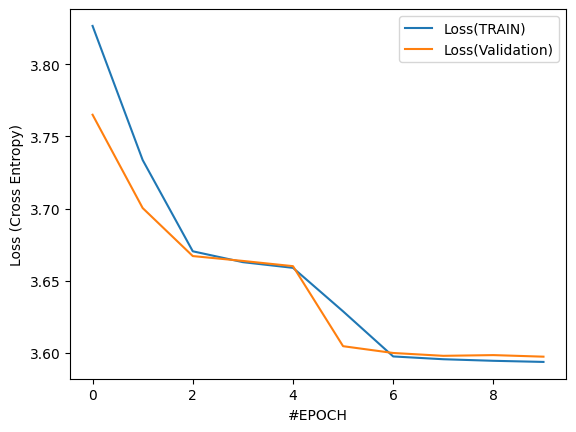

In [20]:
plt.plot(avg_losses[20:30], label='Loss(TRAIN)')
plt.plot(val_avg_losses[20:30], label='Loss(Validation)')
plt.xlabel('#EPOCH')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()